In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import quandl
import quandl as q
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [2]:
#pega os dados da API
msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


In [3]:
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Adj_Close']]


In [ ]:
#train = daily_close.loc['2013-09-03':'2017-12-21']
#test = daily_close.loc['2017-12-22':]
k = 30
train = daily_close[:k]
test = daily_close[k:]

step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

#print(step_model.aic())

step_model.fit(train)

future_forecast = step_model.predict(n_periods = len(test))

future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])

pd.concat([test,future_forecast],axis=1).plot()

pd.concat([daily_close,future_forecast],axis=1).plot(linewidth = 1)

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(future_forecast.values, test.values)

In [ ]:
for k in range(30,50):
    train = daily_close[:k]
    test = daily_close[k:]

    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                           seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings  = True,
                           stepwise = False)
    
    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])

    mape = np.mean(np.abs(future_forecast.values - test.values)/np.abs(test.values))  # MAPE
    lul = [step_model, mape, i]
    infos.append(lul)

In [4]:
def getlinear_coefi(x,y):
    
    m = (len(x) * np.sum(x*y) - np.sum(x) * np.sum(y)) / (len(x)*np.sum(x*x) - np.sum(x) * np.sum(x))
    return m

def train_model_and_forecast(train, test):
    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])
    
    y = []
    x = []
    
    forecast_n = future_forecast.values[0]
    daily_n = train.values[len(train)-1]
    
    for el in future_forecast.values:
        x.append(float(el))
    for i in range(len(future_forecast.values)):
        y.append(i)
        
    return [x,y,forecast_n,daily_n]

In [ ]:
compra = []
venda = []
dif_compra = 0.1
m_n_1 = 1
forecast_n = 1
forecast_n_1 = 1
daily_n_1 = 1
for k in range(30,len(daily_close[:100])):
    train = daily_close[k-10:k-1]
    test = daily_close[k:k+15]

    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])
    
    y = []
    x = []
    
    forecast_n = future_forecast.values[0]
    daily_n = train.values[len(train)-1]
    
    for el in future_forecast.values:
        x.append(float(el))
    for i in range(len(future_forecast.values)):
        y.append(i)

    m = getlinear_coefi(np.array(x),np.array(y))
    m_n = m
    
    
    if m_n_1 < -10:
        if (forecast_n_1 - daily_n_1)/forecast_n_1 > 0.5/100:
            print('compra:')
            print(k)
            compra.append(k)

    print(k,forecast_n_1,daily_n_1,(forecast_n_1 - daily_n_1)/forecast_n_1,m_n_1)
    forecast_n_1 = forecast_n
    daily_n_1 = daily_n    
    m_n_1 = m_n
   

In [6]:
compra = []
venda = []
dif_compra = 0.1
m_n_1 = 1
forecast_n = 1
forecast_n_1 = 1
daily_n_1 = 1
for k in range(30,len(daily_close[:50])):
    train = daily_close[k-10:k-1]
    test = daily_close[k:k+15]
    
    resultado_modelo = train_model_and_forecast(train, test)
    m = getlinear_coefi(np.array(resultado_modelo[0]),np.array(resultado_modelo[1]))
    m_n = m
    forecast_n = resultado_modelo[2]
    daily_n = resultado_modelo[3]
    
    if m_n_1 < -10:
        if (forecast_n_1 - daily_n_1)/forecast_n_1 > 0.5/100:
            print('compra:')
            print(k)
            compra.append(k)

    print(k,forecast_n_1,daily_n_1,(forecast_n_1 - daily_n_1)/forecast_n_1,m_n_1)
    forecast_n_1 = forecast_n
    daily_n_1 = daily_n    
    m_n_1 = m_n
   

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.658, BIC=8.816, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.376, BIC=9.614, Time=0.034 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=9.056, BIC=9.453, Time=0.236 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=9.349, BIC=9.587, Time=0.019 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.111, BIC=12.429, Time=0.220 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=10.749, BIC=11.225, Time=0.169 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=10.549, BIC=10.867, Time=0.038 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=9.079, BIC=9.476, Time=0.174 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=11.868, BIC=12.

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=0.246, BIC=0.485, Time=0.049 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=3.009, BIC=3.407, Time=0.190 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-0.071, BIC=0.168, Time=0.044 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.898, BIC=2.215, Time=0.095 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=4.729, BIC=5.205, Time=0.279 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1.882, BIC=2.199, Time=0.065 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=3.010, BIC=3.407, Time=0.244 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=7.026, BIC=7.582, Time=0.318 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=3.766, BIC=4.163, Ti

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.065 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=24.267, BIC=24.664, Time=0.147 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=22.418, BIC=22.656, Time=0.017 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=24.266, BIC=24.584, Time=0.067 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=26.141, BIC=26.618, Time=0.212 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=23.415, BIC=23.732, Time=0.027 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=23.934, BIC=24.331, Time=0.194 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=28.142, BIC=28.698, Time=0.246 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=24.970, BIC=25.368, Time=0.077 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=25.27

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.719, BIC=12.957, Time=0.111 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=13.506, BIC=13.903, Time=0.183 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=11.695, BIC=11.933, Time=0.032 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.539, BIC=11.856, Time=0.126 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=13.578, BIC=14.054, Time=0.231 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=11.327, BIC=11.645, Time=0.078 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=13.367, BIC=13.764, Time=0.203 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=15.323, BIC=15.879, Time=0.321 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=12.89

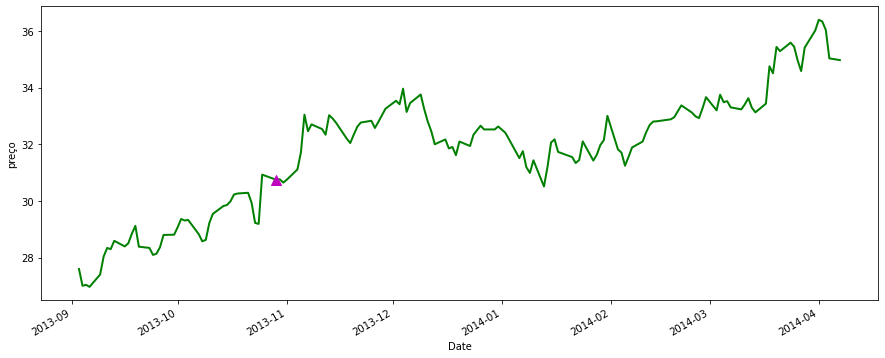

In [7]:
fig = plt.figure()

plt1 = fig.add_subplot(111,  ylabel='preço')

msft_data['Adj_Close'][:150].plot(ax=plt1, color='g', lw=2.)

# venda
plt1.plot(msft_data['Adj_Close'][venda], 'v', markersize=10, color='r')

# compra
plt1.plot(msft_data['Adj_Close'][compra], '^', markersize=10, color='m')
         
# show
plt.show()

In [ ]:
preco_venda = []
preco_compra = []
venda_total = 0
compra_total = 0
for el in venda:
    preco_venda.append(msft_data['Adj_Close'][el])
    venda_total = venda_total + msft_data['Adj_Close'][el]
for el in compra:
    preco_compra.append(msft_data['Adj_Close'][el])
    compra_total = compra_total + msft_data['Adj_Close'][el]

In [ ]:
compra

In [ ]:
venda